In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', 500) ## show more columns

# Analysis of Presidential22 dataset
This section is used to analyze the Presidential22 dataset

In [3]:
from datasets import load_presidential22, feature_engineering, remove_presidential22_extra_columns

dataset = load_presidential22()
#dataset = feature_engineering(dataset)
dataset.sample(n=3)

dataset = feature_engineering(dataset)
dataset_model = remove_presidential22_extra_columns(dataset)
dataset.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 40217 entries, 865250843527979008 to 1286324749199712256
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   nb_tweets                     40217 non-null  int64              
 1   matching_rules                40217 non-null  object             
 2   probe_date                    40217 non-null  datetime64[ns, UTC]
 3   statuses_count                40217 non-null  int64              
 4   followers_count               40217 non-null  int64              
 5   friends_count                 40217 non-null  int64              
 6   favourites_count              40217 non-null  int64              
 7   listed_count                  40217 non-null  int64              
 8   description                   40217 non-null  object             
 9   screen_name                   40217 non-null  object             
 10  nam

In [6]:
import joblib
clf = joblib.load('rf-model.pkl')
bool_mask = clf.predict(dataset_model.select_dtypes(include=['int64', 'float64', 'bool']))

dataset['label'] = bool_mask

C:\Users\Obyka\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Obyka\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
print(dataset[dataset['verified'] == True]['label'].sum())

0


In [8]:
print('Sample of legitimate users:')

for idx, profile in dataset[bool_mask == 0].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))
    #print(profile)
    print('\n')

Sample of legitimate users:
https://twitter.com/Joubertcitoyens


https://twitter.com/YenneferQ


https://twitter.com/_Dalla00


https://twitter.com/FarA2020tHin


https://twitter.com/Kadim55525174


https://twitter.com/WHY90299440


https://twitter.com/Gs59120785G


https://twitter.com/macSL0171


https://twitter.com/Peiretaillade


https://twitter.com/sj92_lasauce




In [9]:
print('Sample of bot users:')
for idx, profile in dataset[bool_mask == 1].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))
    #print(profile)
    print('\n')

Sample of bot users:
https://twitter.com/Lna27993134


https://twitter.com/Pascal_LM_


https://twitter.com/Break08Stephane


https://twitter.com/HautaGarona


https://twitter.com/Xakiru


https://twitter.com/humauaka


https://twitter.com/carmagnolelibre


https://twitter.com/HNourine94


https://twitter.com/Crackerinhoo


https://twitter.com/FCBarcelonisto




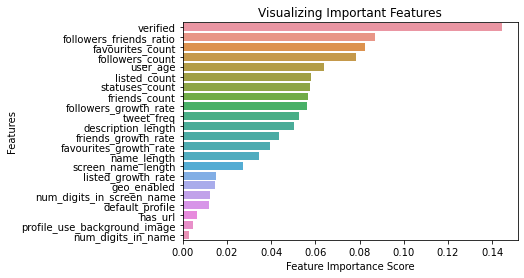

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
feature_imp = pd.Series(clf.feature_importances_,index=dataset_model.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Analysis of Twibot-20 dataset
This section is used to analyze the Twibot-20 dataset (https://arxiv.org/abs/2106.13088)

## Load the train and test datasets

In [11]:
from datasets import load_twibot20

twibot20_train = load_twibot20(dataset='train')
twibot20_test = load_twibot20(dataset='test')

ValueError: Expected object or value

## Analyse the datatests

In [ ]:
twibot20_train.describe()

In [ ]:
twibot20_test.describe()

Although the train and test datasets are split into two files, we could merge them together and separate them ourselves.

The train and test datasets have 8278 and 1183 entries, respectively.

In [ ]:
twibot20_train.info()

In [ ]:
twibot20_train.sample(3)

The dataset contains various information provided by the Twitter API. We have access to the account name called "name", the unique username called "screen_name", the location, the description, the number of followers/friends/lists/favorites/statuses, the date of creation, if the account has been verified by Twitter. All the attributes and their description are available at https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user.

Two additional columns are present: the label identifies whether the user is a bot (1) or not (0), the probe_date is used to describe when the data was collected.

Many columns are irrelevant for the detection of bots, we can remove them. We start with the boolean columns:

In [ ]:
for col in twibot20_train.select_dtypes(include=['bool']).columns:
    print(f"{col}:")
    print(twibot20_train[col].value_counts())
    print('')

We conclude that the protected column can be removed as the values are mostly False and it has been deprecated by the Twitter API. We can remove contributors_enabled, is_translation_enabled, is_translator and profile_location for the same reasons.

We also remove columns that only contain empty values and irrelevant columns (colors, profile/background urls). 

In [ ]:
from datasets import remove_useless_api_columns

twibot20_train = remove_useless_api_columns(twibot20_train)
twibot20_test = remove_useless_api_columns(twibot20_test)
twibot20_train.info()

## Feature engineering
At the moment we are somewhat limited in the number of available features. We will use feature engineering with methods found in (https://arxiv.org/abs/1911.09179), as well as our own features.

(https://arxiv.org/abs/1911.09179) adds the user_age, tweet_freq, followers/friends/favourites/listed_growth_rate, followers_friends_ratio, (screen_)name_length, description_length, num_digits_in_(screen_)name. We also replace location and url by two booleans indicating whether the field is non-null.

In [ ]:
from datasets import feature_engineering

twibot20_train = feature_engineering(twibot20_train)
twibot20_train.sort_index(axis=1, inplace=True)

twibot20_test = feature_engineering(twibot20_test)
twibot20_test.sort_index(axis=1, inplace=True)
twibot20_train.info()

In [ ]:
twibot20_train.describe()

In [ ]:
twibot20_train.sample(5)

In [ ]:
twibot20_train[twibot20_train['tweet_freq'] > 100]

## Analysis of the features


In [ ]:
print("Train dataset")
print("Number of users: {}".format(len(twibot20_train)))
print("Number of verified users: {}".format(twibot20_train['verified'].sum()))

In [ ]:
print("Test dataset")
print("Number of users: {}".format(len(twibot20_test)))
print("Number of verified users: {}".format(twibot20_test['verified'].sum()))

In [ ]:
print('Sample of legitimate users:')
for idx, profile in twibot20_train[twibot20_train['label'] == 0].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))

In [ ]:
print('Sample of bots:')
for idx, profile in twibot20_train[twibot20_train['label'] == 1].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))

### 2D PCA analysis

<IPython.core.display.Javascript object>


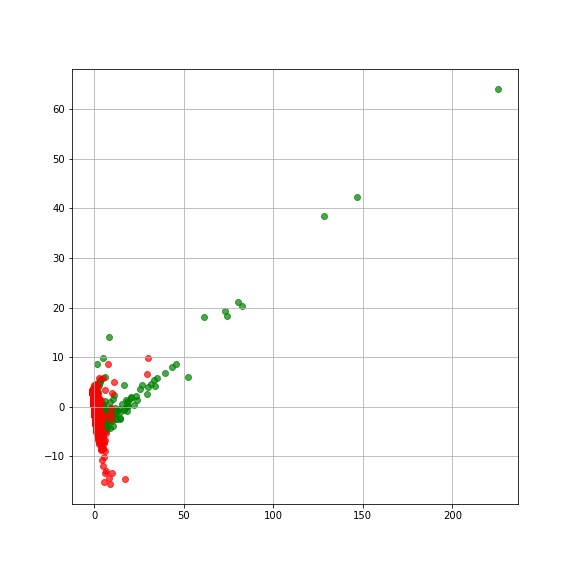

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

def draw_pca(data):
    # PCA analysis only on bool, int64 and float64
    X_raw = data.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
    sc = StandardScaler()
    sc.fit(X_raw)
    
    X = sc.transform(X_raw)    
    y = data['label']

    fig = plt.figure(1, figsize=(8, 8))
    ax = fig.add_subplot(1,1,1)

    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    X = pca.transform(X)

    for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
        ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

    ax.grid()
    plt.show()

%matplotlib notebook
#draw_pca(twibot20_train)
draw_pca(dataset)

### Analysis of the annotation
Quality of the annotation using global data

In [ ]:

# Account reputation based on Chu et al 
def reputation(user):
    a = abs(user['followers_count'])
    b = abs(user['followers_count']) + abs(user['friends_count'])
    
    return a / b if b != 0 else 0

In [ ]:
print('Mean reputation of twibot20_train: {}'.format(twibot20_train.apply(reputation, axis=1).mean()))
print('Mean reputation of twibot20_test : {}\n'.format(twibot20_test.apply(reputation, axis=1).mean()))

print('Mean reputation of bots in twibot20_train: {}'.format(twibot20_train[twibot20_train['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of bots in twibot20_test : {}\n'.format(twibot20_test[twibot20_test['label'] == 1].apply(reputation, axis=1).mean()))

print('Mean reputation of users in twibot20_train: {}'.format(twibot20_train[twibot20_train['label'] == 0].apply(reputation, axis=1).mean()))
print('Mean reputation of users in twibot20_test : {}'.format(twibot20_test[twibot20_test['label'] == 0].apply(reputation, axis=1).mean()))

### Random forest model

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

# PCA analysis only on bool, int64 and float64
X_train = twibot20_train.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_train = twibot20_train['label']

X_test = twibot20_test.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_test = twibot20_test['label']

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train.values, y_train.values)

y_pred=clf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Cresci-2017 dataset
## Loading the dataset

In [ ]:
from datasets import load_cresci17
cresci17_raw = load_cresci17()
cresci17_raw.describe()

In [ ]:
from datasets import remove_cresci17_extra_columns

cresci17 = feature_engineering(remove_useless_api_columns(remove_cresci17_extra_columns(cresci17_raw)))
cresci17.sort_index(axis=1, inplace=True)
cresci17.info()

## PCA analysis

In [ ]:
cresci17.describe()

In [ ]:
%matplotlib notebook
draw_pca(cresci17)

In [ ]:
print('Mean reputation of cresci17 : {}\n'.format(cresci17.apply(reputation, axis=1).mean()))

print('Mean reputation of bots in cresci17 : {}\n'.format(cresci17[cresci17['label'] == 1].apply(reputation, axis=1).mean()))

print('Mean reputation of users in cresci17 : {}'.format(cresci17[cresci17['label'] == 0].apply(reputation, axis=1).mean()))

## Random forest model

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test
X = cresci17.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y = cresci17['label']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train.values, y_train.values)

y_pred=clf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
X_test['verified'].value_counts()

# Midterm-2018 dataset

In [ ]:
from datasets import load_midterm18
midterm18_raw = load_midterm18()
midterm18_raw.info()

In [ ]:
midterm18_raw.sample(3)

In [ ]:
from datasets import remove_midterm18_extra_columns

midterm18 = feature_engineering(remove_useless_api_columns(remove_midterm18_extra_columns(midterm18_raw)))
midterm18.sort_index(axis=1, inplace=True)
midterm18.info()

In [ ]:
midterm18.describe()

We can see that some features (profile_background_tile, location, default_profile_image) are missing from the dataset compared to TwiBot-20 and Cresci-17. This will have to be taken into consideration when mixing datasets.

### PCA analysis

In [ ]:
%matplotlib notebook
draw_pca(midterm18)

In [ ]:
print('Mean reputation of midterm18 : {}\n'.format(midterm18.apply(reputation, axis=1).mean()))

print('Mean reputation of bots in midterm18 : {}\n'.format(midterm18[midterm18['label'] == 1].apply(reputation, axis=1).mean()))

print('Mean reputation of users in midterm18 : {}'.format(midterm18[midterm18['label'] == 0].apply(reputation, axis=1).mean()))

## Random forest model

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test
X = midterm18.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y = midterm18['label']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train.values, y_train.values)

y_pred=clf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Mixing datasets
### Generalization capabilities

First, let's see whether the models trained on a dataset works on other datasets.

In [ ]:
twibot20_bots = twibot20_train[twibot20_train['label'] == 1].apply(reputation, axis=1)
twibot20_users = twibot20_train[twibot20_train['label'] == 0].apply(reputation, axis=1)

cresci17_bots = cresci17[cresci17['label'] == 1].apply(reputation, axis=1)
cresci17_users = cresci17[cresci17['label'] == 0].apply(reputation, axis=1)

midterm18_bots = midterm18[midterm18['label'] == 1].apply(reputation, axis=1)
midterm18_users = midterm18[midterm18['label'] == 0].apply(reputation, axis=1)

In [ ]:
data = [twibot20_bots.values, cresci17_bots.values, midterm18_bots.values, twibot20_users.values, cresci17_users.values, midterm18_users.values]
labels = ['TwiBot-20 Bot', 'Cresci-17 Bot', 'Midterm-18 Bot', 'TwiBot-20 User', 'Cresci-17 User', 'Midterm-18 User']

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Reputation distribution of datasets')
ax.boxplot(data)
ax.set_xticklabels(labels);

In [ ]:
print('Mean reputation of twibot20 : {}'.format(twibot20_train.apply(reputation, axis=1).mean()))
print('Mean reputation of bots in twibot20 : {}'.format(twibot20_train[twibot20_train['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of users in twibot20 : {}\n'.format(twibot20_train[twibot20_train['label'] == 0].apply(reputation, axis=1).mean()))

print('Mean reputation of cresci17 : {}'.format(cresci17.apply(reputation, axis=1).mean()))
print('Mean reputation of bots in cresci17 : {}'.format(cresci17[cresci17['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of users in cresci17 : {}\n'.format(cresci17[cresci17['label'] == 0].apply(reputation, axis=1).mean()))

print('Mean reputation of midterm18 : {}'.format(midterm18.apply(reputation, axis=1).mean()))
print('Mean reputation of bots in midterm18 : {}'.format(midterm18[midterm18['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of users in midterm18 : {}\n'.format(midterm18[midterm18['label'] == 0].apply(reputation, axis=1).mean()))

In [ ]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

%matplotlib notebook

twibot20_pca = twibot20_train.sample(200).copy()
cresci17_pca = cresci17.sample(200).copy()
midterm18_pca = midterm18.sample(200).copy()

twibot20_pca['label'] = twibot20_pca['label'].apply(lambda lbl: ('twibot20', lbl))
cresci17_pca['label'] = cresci17_pca['label'].apply(lambda lbl: ('cresci17', lbl))
midterm18_pca['label'] = midterm18_pca['label'].apply(lambda lbl: ('midterm18', lbl))

data = pd.concat([twibot20_pca, cresci17_pca, midterm18_pca])
X_raw = data.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])

sc = StandardScaler()
sc.fit(X_raw)
X = sc.transform(X_raw)
y = data['label']

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

colors = [(("twibot20", 0), 'green'), (("twibot20", 1), 'lime'),
          (("cresci17", 0), 'blue'), (("cresci17", 1), 'cyan'),
          (("midterm18", 0), 'purple'), (("midterm18", 1), 'magenta')]
for label, c in colors:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()


twibot20_pca = twibot20_pca[0:0]
cresci17_pca = cresci17_pca[0:0]
midterm18_pca = midterm18_pca[0:0]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test
# Drop columns missing from midterm18
X_twibot20 = twibot20_train.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_twibot20 = twibot20_train['label']
X_twibot20_train, X_twibot20_test, y_twibot20_train, y_twibot20_test = train_test_split(X_twibot20, y_twibot20,test_size=0.33, random_state=80)

X_cresci17 = cresci17.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_cresci17 = cresci17['label']
X_cresci17_train, X_cresci17_test, y_cresci17_train, y_cresci17_test = train_test_split(X_cresci17, y_cresci17,test_size=0.33, random_state=80)

X_midterm18 = midterm18.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_midterm18 = midterm18['label']
X_midterm18_train, X_midterm18_test, y_midterm18_train, y_midterm18_test = train_test_split(X_midterm18, y_midterm18,test_size=0.33, random_state=80)

#### Model trained using TwiBot-20

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_train, y_twibot20_train)

y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)
y_midterm18_pred=clf.predict(X_midterm18_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of twibot20   :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print("                     f1:", metrics.f1_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17   :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print("                     f1:", metrics.f1_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))
print("Accuracy on midterm18  :", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print("                     f1:", metrics.f1_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))

"""
              pred
            1       0
          -----   -----
       1 |  TP  |  FP
truth     -----   -----
       0 |  FN  |  TN
""";

In [ ]:
y_twibot20_test.sum()

#### Model trained using Cresci-17

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_cresci17_train, y_cresci17_train)

y_cresci17_pred=clf.predict(X_cresci17_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_midterm18_pred=clf.predict(X_midterm18_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))

#### Model trained using Midterm-18

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_midterm18_train, y_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Use only 5000 sample of each
from sklearn.model_selection import train_test_split

rand = 346
# Split the dataset into train, test
twibot20_sample = twibot20_train.sample(8000, random_state=rand)
cresci17_sample = cresci17.sample(3000, random_state=rand)
midterm18_sample = midterm18.sample(5000, random_state=rand)

# Drop columns missing from midterm18
X_twibot20 = twibot20_sample.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_twibot20 = twibot20_sample['label']
X_twibot20_train, X_twibot20_test, y_twibot20_train, y_twibot20_test = train_test_split(X_twibot20, y_twibot20,test_size=0.33, random_state=80)

X_cresci17 = cresci17_sample.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_cresci17 = cresci17_sample['label']
X_cresci17_train, X_cresci17_test, y_cresci17_train, y_cresci17_test = train_test_split(X_cresci17, y_cresci17,test_size=0.33, random_state=80)

X_midterm18 = midterm18_sample.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_midterm18 = midterm18_sample['label']
X_midterm18_train, X_midterm18_test, y_midterm18_train, y_midterm18_test = train_test_split(X_midterm18, y_midterm18,test_size=0.33, random_state=80)

In [ ]:
# Cresci + midterm dataset
X_cresci17_midterm18_train = pd.concat([X_cresci17_train, X_midterm18_train])
y_cresci17_midterm18_train = pd.concat([y_cresci17_train, y_midterm18_train])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_cresci17_midterm18_train, y_cresci17_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Twibot + cresci dataset
X_twibot20_cresci17_train = pd.concat([X_twibot20_train, X_cresci17_train ])
y_twibot20_cresci17_train = pd.concat([y_twibot20_train, y_cresci17_train])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_cresci17_train, y_twibot20_cresci17_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Twibot + midterm dataset
X_twibot20_midterm18_train = pd.concat([X_twibot20_train, X_cresci17_train ])
y_twibot20_midterm18_train = pd.concat([y_twibot20_train, y_cresci17_train])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_midterm18_train, y_twibot20_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
X_verified19 = verified19.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_verified19 = verified19['label']

clf.predict(X_verified19).sum()

In [ ]:
# Extract the model
import joblib
joblib.dump(clf, 'rf-model.pkl')

In [ ]:
# Restore the model
import joblib
clf_copy = joblib.load('rf-model.pkl')
clf_copy.predict(X_verified19).sum()

In [ ]:
# Applying to a human dataset
def load_verified_2019():
    file_users = "../verified-2019/verified-2019_tweets.json"
    file_bots = "../verified-2019/verified-2019.tsv"

    raw = pd.read_json(file_users)
    labels = pd.read_csv(file_bots, names=['id', 'label'], sep='\t')    

    profiles = pd.json_normalize(raw['user'])
    profiles.drop(['id_str', 
                   'profile_background_image_url_https', 
                   'profile_image_url_https'], axis=1, inplace=True)
    profiles['label'] = 0
    profiles['probe_date'] = raw['created_at']

    # Convert columns to integer
    profiles[['id', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count', 'label']] = profiles[['id', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count', 'label']].apply(pd.to_numeric)
    profiles.set_index('id', inplace=True)

    # Convert strings to dates
    profiles['created_at'] = profiles['created_at'].apply(pd.to_datetime, utc=True)
    profiles['probe_date'] = profiles['probe_date'].apply(pd.to_datetime, utc=True)

    # Replace "True ", "False ", "None " by python types
    profiles.replace({'True ': True, 'False ': False, 'None ': None}, inplace=True)

    return profiles

verified19 = feature_engineering(remove_useless_api_columns(load_verified_2019()))
verified19.drop(['notifications', 'following', 'profile_banner_url', 'translator_type', 'entities.url.urls', 'entities.description.urls', 'follow_request_sent'], axis=1, inplace=True)
verified19.sort_index(axis=1, inplace=True)
verified19.info()

In [ ]:
profiles

In [ ]:
profiles['user'][0]

In [ ]:
X_cresci17_midterm18_train.columns.values

In [ ]:
np.sort(X_cresci17_train.columns.values) == np.sort(X_cresci17_midterm18_train.columns.values)

In [ ]:
clf.predict(twibot20_train[twibot20_train['name'] == 'OConnellFanClub '].values)

# Random code

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

Y_train = train_features['label']
X_train = train_features.drop(['label'], axis=1)

Y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)
# Split dataset into training set and test set

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values,Y_train.values)

y_pred=clf.predict(X_test.values)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
profiles = [profile for profile in train_raw_data[train_raw_data["label"] == 0].sample(n=30)["profile"]]
for profile in profiles:
    print("https://twitter.com/"+str(profile['screen_name'])+"\n")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features.drop(['label'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features['label']

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features.drop(['label'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features['label']

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
    ax.scatter(X[y == label, 0], X[y == label, 1], X[y == label, 2], c=c, alpha=0.7)
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
#ax.scatter(X[y , 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="c")

ax.set_xlim3d(-10,20)
ax.set_zlim3d(-10,10)

fig.add_axes(ax)

plt.show()

In [ ]:
%matplotlib notebook

import pandas as pd
import numpy as np

files_genuine = ["../cresci-2017.csv/genuine_accounts.csv/users.csv"]
files_bots = ["../cresci-2017.csv/traditional_spambots_1.csv/users.csv",
              "../cresci-2017.csv/traditional_spambots_2.csv/users.csv",
              "../cresci-2017.csv/traditional_spambots_3.csv/users.csv",
              "../cresci-2017.csv/traditional_spambots_4.csv/users.csv",
              "../cresci-2017.csv/social_spambots_1.csv/users.csv",
              "../cresci-2017.csv/social_spambots_2.csv/users.csv",
              "../cresci-2017.csv/social_spambots_3.csv/users.csv"]

train_raw_data_genuine = pd.concat((pd.read_csv(f) for f in files_genuine))
train_raw_data_genuine['label'] = 0

train_raw_data_bots = pd.concat((pd.read_csv(f) for f in files_bots))
train_raw_data_bots['label'] = 1

train_raw_data = pd.concat((train_raw_data_genuine, train_raw_data_bots))
train_raw_data = train_raw_data.rename(columns={})

train_profile = train_raw_data

train_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]] = train_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]].apply(pd.to_numeric, errors='coerce', axis=1)

train_profile.set_index('id', inplace=True)

#Douteux
#train_profile = train_profile.replace([0], 1)

def date_converter(dt):
    try:
        return pd.to_datetime(dt)
    except:
        return pd.to_datetime("1185440851000", unit="ms", utc=True)

train_profile.created_at = train_profile.created_at.apply(date_converter)

train_labels = train_raw_data["label"].values
train_dict = {"statuses_count":train_profile.statuses_count, 
                "followers_count":train_profile.followers_count, 
                "friends_count":train_profile.friends_count, 
                "favourites_count":train_profile.favourites_count, 
                "listed_count":train_profile.listed_count, 
                "default_profile":train_profile.default_profile,
                "profile_use_background_image":train_profile.profile_use_background_image,
                "verified":train_profile.verified,
                "user_age":(pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days,
                "tweet_freq": np.nan_to_num(train_profile.statuses_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "followers_growth_rate": np.nan_to_num(train_profile.followers_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "friends_growth_rate" : np.nan_to_num(train_profile.friends_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "favourites_growth_rate" : np.nan_to_num(train_profile.favourites_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "listed_growth_rate" : np.nan_to_num(train_profile.listed_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "followers_friends_ratio" : np.nan_to_num(train_profile.followers_count / train_profile.friends_count, posinf=0.0),
                "screen_name_length": train_profile.screen_name.str.len(),
                "num_digits_in_screen_name": train_profile.screen_name.str.count('\d'),
                "name_length": train_profile.name.str.len(),
                "num_digits_in_name": train_profile.name.str.count('\d'),
                "description_length": train_profile.description.str.len(),
                 "label":train_labels
               }
train_features2 = pd.DataFrame(data=train_dict)
train_features2 = train_features2.replace({'True ': True, 'False ': False})
train_features2 = train_features2.fillna(0)
train_features2.default_profile = train_features2.default_profile.astype(bool)
train_features2.verified = train_features2.verified.astype(bool)
train_features2.profile_use_background_image = train_features2.profile_use_background_image.astype(bool)

train_features2.describe()

In [ ]:
train_profile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features2.drop(['label', 'verified'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features2['label']

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features2.drop(['label'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features2['label']

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
    ax.scatter(X[y == label, 0], X[y == label, 1], X[y == label, 2], c=c, alpha=0.7)
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
#ax.scatter(X[y , 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="c")


fig.add_axes(ax)
ax.set_xlim3d(0,50)
ax.set_ylim3d(-10,30)
ax.set_zlim3d(-10,10)


plt.show()

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

y = train_features2['label']
X = train_features2.drop(['label'], axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)

y_pred = clf.predict(X_test.values)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
indexes = X_test[y_pred == 1].index
profiles = test_profile.loc[test_profile.index.isin(indexes)]
for i, profile in profiles.iterrows():
    print("https://twitter.com/"+profile.screen_name+"\n")

In [ ]:
profiles.values

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
%matplotlib notebook

import pandas as pd
import numpy as np

file_users = "../midterm-2018_processed_user_objects.json"
file_bots = "../midterm-2018.tsv"

midterm2018_profile = pd.read_json(file_users)
midterm2018_labels = pd.read_csv(file_bots, names=['id', 'label'], sep='\t')

midterm2018_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]] = midterm2018_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]].apply(pd.to_numeric, errors='coerce', axis=1)

midterm2018_profile = midterm2018_profile.rename(columns={'user_id': 'id'})

midterm2018_profile.set_index('id', inplace=True)
midterm2018_labels.set_index('id', inplace=True)

def date_converter(dt):
    try:
        return pd.to_datetime(dt)
    except:
        return pd.to_datetime("1185440851000", unit="ms")

midterm2018_profile.probe_timestamp = midterm2018_profile.probe_timestamp.apply(date_converter)
midterm2018_labels.label = midterm2018_labels.label.apply(lambda l: 1 if l == 'bot' else 0)

In [ ]:
midterm2018_dict = {"statuses_count":midterm2018_profile.statuses_count, 
                "followers_count":midterm2018_profile.followers_count, 
                "friends_count":midterm2018_profile.friends_count, 
                "favourites_count":midterm2018_profile.favourites_count, 
                "listed_count":midterm2018_profile.listed_count, 
                "default_profile":midterm2018_profile.default_profile,
                "profile_use_background_image":midterm2018_profile.profile_use_background_image,
                "verified":midterm2018_profile.verified,
                "user_age":(pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days,
                "tweet_freq": np.nan_to_num(midterm2018_profile.statuses_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "followers_growth_rate": np.nan_to_num(midterm2018_profile.followers_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "friends_growth_rate" : np.nan_to_num(midterm2018_profile.friends_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "favourites_growth_rate" : np.nan_to_num(midterm2018_profile.favourites_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "listed_growth_rate" : np.nan_to_num(midterm2018_profile.listed_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "followers_friends_ratio" : np.nan_to_num(midterm2018_profile.followers_count / midterm2018_profile.friends_count, posinf=0.0),
                "screen_name_length": midterm2018_profile.screen_name.str.len(),
                "num_digits_in_screen_name": midterm2018_profile.screen_name.str.count('\d'),
                "name_length": midterm2018_profile.name.str.len(),
                "num_digits_in_name": midterm2018_profile.name.str.count('\d'),
                "description_length": midterm2018_profile.description.str.len(),
               }

midterm2018_features = pd.DataFrame(data=midterm2018_dict)
midterm2018_features = pd.concat([midterm2018_features, midterm2018_labels], axis=1)
midterm2018_features = midterm2018_features.fillna(0)

midterm2018_features.describe()

In [ ]:
midterm2018_features.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = midterm2018_features.drop(['label', 'verified'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = midterm2018_features['label']

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.xlim(-8, 50)
plt.ylim(-10,55)
plt.show()

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

y = midterm2018_features['label']
X = midterm2018_features.drop(['label'], axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)

y_pred = clf.predict(X_test.values)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
train_features2

In [ ]:
midterm2018_features

In [ ]:
midterm2018_cresci17_features = pd.concat([midterm2018_features.sample(n = 10000), train_features2.sample(n = 10000)])
midterm2018_cresci17_features

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

y = midterm2018_cresci17_features['label']
X = midterm2018_cresci17_features.drop(['label'], axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
y_test = train_features2['label']
X_test = train_features2.drop(['label'], axis=1)

y_pred = clf.predict(X_test.values)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


In [ ]:
indexes = X_test[y_pred == 1].index
profiles = train_profile.loc[test_profile.index.isin(indexes)]
for i, profile in profiles.iterrows():
    print("https://twitter.com/"+profile.screen_name+"\n")

In [ ]:
indexes = X_test[y_pred == 1].index
profiles = train_profile.loc[test_profile.index.isin(indexes)]

In [ ]:
midterm2018_features[midterm2018_features.statuses_count < 5]